In [194]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stat
import numpy.linalg as LA
import pysal
from pysal.esda.moran import Moran
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import geopandas as gp
import matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [217]:
#Compute Eigenvalues and Eigenvectors from the 
#transformed Spatial weights Matrix usuibg python/numpy

#It says in the paper that a rook-case binary contiguity wieghts matrix
#is being used, so that is what I employ here.
neighbor_list = '/users/toshan/projects/GWR_SF/georgia_rook.gal'
style = 'b'


w = pysal.open(neighbor_list).read()
w.transform = style
C, ids = pysal.full(w)
#C = 0.5 * (C + C.T)
n = C.shape[0]
M = np.identity(n) - (np.float(1)/np.float(n))
MCM = np.dot(np.dot(M,C),M)
vals, vecs = LA.eig(MCM)

##Take transpose to get vectors from first dimension
vals, vecs = np.array(vals), np.array(vecs.T)


pairs = zip(vals, vecs)
svals = sorted(vals, reverse=True)


stups = [None] * len(svals)
for e_val, vector in pairs:
    stups[svals.index(e_val)] = (e_val, vector)

In [218]:
new_vecs = np.array([x[1] for x in stups])
new_vals = np.array([x[0] for x in stups])

In [219]:
#Compute Eigenvalues and Eigenvectors from the 
#transformed Spatial weights Matrix using R

#It says in the paper that a rook-case binary contiguity wieghts matrix
#is being used, so that is what I employ here.
spdep = importr("spdep")
georgia_rook = spdep.read_gal("/Users/toshan/projects/GWR_SF/georgia_rook.gal", override_id = True)
base = importr("base")

M_r = np.array(ro.r('diag(1,159)-1/159'))
C_r = spdep.nb2listw(georgia_rook, style="B")
C_r = np.array(spdep.listw2mat(C_r))

ro.globalenv["M_r"] = M_r
ro.globalenv["C_r"] = C_r

MCM_r = ro.r('M_r%*%C_r%*%M_r')
ro.globalenv["MCM_r"] = MCM_r

vals_r, vecs_r = MCM_r.eigen()
#Take transpose to get eigenvectors from first dimension
vals_r, vecs_r = np.array(vals_r), np.array(vecs_r).T

In [220]:
print np.allclose(new_vals, vals_r)
print np.allclose(vals, vals_r)
print np.allclose(vals, new_vals)

True
False
False


In [221]:
#Correlations for sorted Python eigenvectors and R eigenvectors
s_cors = []
for i, vec in enumerate(new_vecs):
    s_cors.append(stat.pearsonr(vec, vecs_r[i])[0])
s_cors = np.array(s_cors)


In [222]:
#Correlations for unsorted Python eigenvectors and R eigenvectors
cors = []
for i, vec in enumerate(vecs):
    cors.append(stat.pearsonr(vec, vecs_r[i])[0])
cors = np.array(cors)


In [223]:
print np.allclose(cors, s_cors)


False


In [224]:
#Same results for Spatial Weight
print np.array_equal(C_r, C)

#Same results for M
print np.array_equal(M_r, M)

#Results for MCM vary slightly between R and Pthyon - seems like rounding errors
print np.array_equal(MCM_r, MCM)

#Rounding to the 14th digit results in consistent MCM between R and Python
print np.array_equal(np.round(MCM_r, decimals=14), np.round(MCM, decimals=14))

                     
#Same results for Eigenvalues if we similarly round them after sorting them
print np.array_equal(np.sort(np.round(vals,11)), np.sort(np.round(vals_r,11)))

#Same does not hold for Eigenvectors, which led me to the fact that the python and R eigenvectors
#were provided in differnt orders
print np.array_equal(np.sort(np.round(vecs,4)), np.sort(np.round(vecs_r,4)))

True
True
False
True
True
False


In [225]:
for x, eig in enumerate(vecs[:40]):
    georgia['E' + str(x+1)] = eig

intercept = 11.65947
elderly = .01827 - .57455*georgia['E7'] + 2.68529*georgia['E9'] - 1.43008*georgia['E32']
pop = .0004740 + .00053444*georgia['E5'] - .0034627*georgia['E21'] + .00027500*georgia['E28'] + .00008588*georgia['E29'] - .00049085*georgia['E37'] + .0052024*georgia['E38']
rural = -.02164 - .40283*georgia['E9'] - .07260*georgia['E17'] - .29333*georgia['E23'] - .21945*georgia['E30'] + .17920*georgia['E37']
foreign = 2.53632 + 7.88189*georgia['E1'] + 14.51402*georgia['E2'] - 4.80336*georgia['E4'] - 10.02322*georgia['E5'] - 9.54772*georgia['E9'] + 6.13165*georgia['E13'] + 4.46841*georgia['E15'] - 8.26015*georgia['E20'] + 8.95200*georgia['E22'] + 3.31062*georgia['E25'] - 8.83627*georgia['E28'] - 6.88889*georgia['E32'] - 17.36410*georgia['E38'] + 5.23183*georgia['E40']
poverty = -.26300 + .80033*georgia['E23'] + .26817*georgia['E28'] + .54815*georgia['E30']
black = .06104 - .7218*georgia['E1'] + .13764*georgia['E21'] - .17630*georgia['E22'] + .65026*georgia['E32']

georgia['yhat'] = intercept + elderly*georgia['PctEld'] + pop*georgia['TotPop90'] + rural*georgia['PctRural'] + foreign*georgia['PctFB'] + poverty*georgia['PctPov'] + black*georgia['PctBlack']
print stat.pearsonr(georgia['PctBach'], georgia['yhat'])[0]**2

0.460927034654


In [226]:
w = pysal.open(neighbor_list).read()
MI = []
for each in vecs[:40]:
    m = Moran(each, w, transformation='b')
    MI.append(m.I)
    
MI.sort(reverse=True)
MI

[1.0790660847227049,
 1.0418805220804448,
 1.0254977042841851,
 0.98288559452996738,
 0.94308034331807766,
 0.92444784132219193,
 0.90495775740328233,
 0.85669143119083457,
 0.85115772662466915,
 0.83438328129510331,
 0.79659733031871272,
 0.77749974310264747,
 0.76292173407078001,
 0.73623347723171972,
 0.70575011581586544,
 0.67969050969027489,
 0.65225770070344014,
 0.64421442458043721,
 0.62934596196578274,
 0.60447710019149792,
 0.5841577446836167,
 0.57732643351044288,
 0.54222417708678006,
 0.52866738622362475,
 0.50942277926472168,
 0.49567322553247867,
 0.46708533059505353,
 0.45097228173196219,
 0.43662916903997762,
 0.42817432335901945,
 0.3996026601284049,
 0.37967473255956191,
 0.36164779405152925,
 0.35274354867300139,
 0.34757301695302945,
 0.33140953215011926,
 0.32290682938587134,
 0.31160329742398585,
 0.30711081186478345,
 0.27733499873276879]

In [227]:
for x, eig in enumerate(vecs_r[:40]):
    georgia['E' + str(x+1)] = eig

intercept = 11.65947
elderly = .01827 - .57455*georgia['E7'] + 2.68529*georgia['E9'] - 1.43008*georgia['E32']
pop = .0004740 + .00053444*georgia['E5'] - .0034627*georgia['E21'] + .00027500*georgia['E28'] + .00008588*georgia['E29'] - .00049085*georgia['E37'] + .0052024*georgia['E38']
rural = -.02164 - .40283*georgia['E9'] - .07260*georgia['E17'] - .29333*georgia['E23'] - .21945*georgia['E30'] + .17920*georgia['E37']
foreign = 2.53632 + 7.88189*georgia['E1'] + 14.51402*georgia['E2'] - 4.80336*georgia['E4'] - 10.02322*georgia['E5'] - 9.54772*georgia['E9'] + 6.13165*georgia['E13'] + 4.46841*georgia['E15'] - 8.26015*georgia['E20'] + 8.95200*georgia['E22'] + 3.31062*georgia['E25'] - 8.83627*georgia['E28'] - 6.88889*georgia['E32'] - 17.36410*georgia['E38'] + 5.23183*georgia['E40']
poverty = -.26300 + .80033*georgia['E23'] + .26817*georgia['E28'] + .54815*georgia['E30']
black = .06104 - .7218*georgia['E1'] + .13764*georgia['E21'] - .17630*georgia['E22'] + .65026*georgia['E32']

georgia['yhat'] = intercept + elderly*georgia['PctEld'] + pop*georgia['TotPop90'] + rural*georgia['PctRural'] + foreign*georgia['PctFB'] + poverty*georgia['PctPov'] + black*georgia['PctBlack']
print stat.pearsonr(georgia['PctBach'], georgia['yhat'])[0]**2

0.359500877476


In [228]:
w = pysal.open(neighbor_list).read()
MI = []
for each in vecs_r[:40]:
    m = Moran(each, w, transformation='b')
    MI.append(m.I)
    
MI.sort(reverse=True)
MI

[1.0790660847227047,
 1.0418805220804448,
 1.0254977042841853,
 0.98288559452996749,
 0.943080343318078,
 0.92444784132219238,
 0.90495775740328233,
 0.85669143119083457,
 0.85115772662466893,
 0.83438328129510342,
 0.79659733031871272,
 0.77749974310264724,
 0.76292173407078012,
 0.73623347723171995,
 0.70575011581586533,
 0.67969050969027467,
 0.65225770070344014,
 0.64421442458043721,
 0.62934596196578263,
 0.60447710019149792,
 0.58415774468361681,
 0.57732643351044288,
 0.54222417708677995,
 0.52866738622362464,
 0.50942277926472168,
 0.49567322553247872,
 0.46708533059505364,
 0.45097228173196219,
 0.43662916903997762,
 0.42817432335901945,
 0.39960266012840484,
 0.37967473255956197,
 0.36164779405152919,
 0.35274354867300128,
 0.34757301695302945,
 0.3314095321501192,
 0.3229068293858714,
 0.31160329742398585,
 0.30711081186478351,
 0.27733499873276873]

In [229]:
for x, eig in enumerate(new_vecs[:40]):
    georgia['E' + str(x+1)] = eig

intercept = 11.65947
elderly = .01827 - .57455*georgia['E7'] + 2.68529*georgia['E9'] - 1.43008*georgia['E32']
pop = .0004740 + .00053444*georgia['E5'] - .0034627*georgia['E21'] + .00027500*georgia['E28'] + .00008588*georgia['E29'] - .00049085*georgia['E37'] + .0052024*georgia['E38']
rural = -.02164 - .40283*georgia['E9'] - .07260*georgia['E17'] - .29333*georgia['E23'] - .21945*georgia['E30'] + .17920*georgia['E37']
foreign = 2.53632 + 7.88189*georgia['E1'] + 14.51402*georgia['E2'] - 4.80336*georgia['E4'] - 10.02322*georgia['E5'] - 9.54772*georgia['E9'] + 6.13165*georgia['E13'] + 4.46841*georgia['E15'] - 8.26015*georgia['E20'] + 8.95200*georgia['E22'] + 3.31062*georgia['E25'] - 8.83627*georgia['E28'] - 6.88889*georgia['E32'] - 17.36410*georgia['E38'] + 5.23183*georgia['E40']
poverty = -.26300 + .80033*georgia['E23'] + .26817*georgia['E28'] + .54815*georgia['E30']
black = .06104 - .7218*georgia['E1'] + .13764*georgia['E21'] - .17630*georgia['E22'] + .65026*georgia['E32']

georgia['yhat'] = intercept + elderly*georgia['PctEld'] + pop*georgia['TotPop90'] + rural*georgia['PctRural'] + foreign*georgia['PctFB'] + poverty*georgia['PctPov'] + black*georgia['PctBlack']
print stat.pearsonr(georgia['PctBach'], georgia['yhat'])[0]**2

0.457540978121


In [230]:
w = pysal.open(neighbor_list).read()
MI = []
for each in new_vecs[:40]:
    m = Moran(each, w, transformation='b')
    MI.append(m.I)
    
MI.sort(reverse=True)
MI

[1.0790660847227049,
 1.0418805220804448,
 1.0254977042841851,
 0.98288559452996738,
 0.94308034331807766,
 0.92444784132219193,
 0.90495775740328233,
 0.85669143119083457,
 0.85115772662466915,
 0.83438328129510331,
 0.79659733031871272,
 0.77749974310264747,
 0.76292173407078001,
 0.73623347723171972,
 0.70575011581586544,
 0.67969050969027489,
 0.65225770070344014,
 0.64421442458043721,
 0.62934596196578274,
 0.60447710019149792,
 0.5841577446836167,
 0.57732643351044288,
 0.54222417708678006,
 0.52866738622362475,
 0.50942277926472168,
 0.49567322553247867,
 0.46708533059505353,
 0.45097228173196219,
 0.43662916903997762,
 0.42817432335901945,
 0.3996026601284049,
 0.37967473255956191,
 0.36164779405152925,
 0.35274354867300139,
 0.34757301695302945,
 0.33140953215011926,
 0.32290682938587134,
 0.31160329742398585,
 0.30711081186478345,
 0.27733499873276879]

In [231]:
#Where do expect sorted python results and R results to differ
for i, vec, in enumerate(new_vecs):
    print np.allclose(vec, vecs_r[i])

True
True
False
False
True
True
True
False
True
True
True
False
False
False
False
False
True
True
True
False
True
True
True
True
True
True
False
True
True
False
False
True
False
True
True
True
True
False
False
True
False
False
False
True
True
True
True
True
False
True
True
False
True
True
False
False
True
True
True
False
True
True
True
True
True
False
False
True
False
False
False
True
False
False
True
True
True
True
True
False
True
True
False
False
False
True
False
True
True
True
False
True
True
True
True
False
False
False
True
False
True
False
False
False
True
False
False
True
True
False
False
False
False
False
True
True
True
True
True
True
False
True
True
True
False
False
True
False
True
False
False
False
True
False
False
False
True
False
True
True
False
False
True
True
False
False
True
False
True
False
False
False
True
True
False
True
True
False
False


In [232]:
#Where do expect unsorted python results to be different from sorted python results
for i, vec, in enumerate(new_vecs):
    print np.allclose(vec, vecs.T[i])

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [233]:
gshp = gp.read_file('georgia.shp')

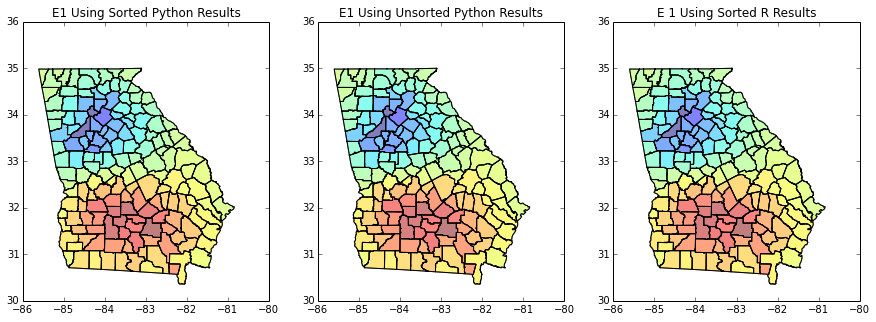

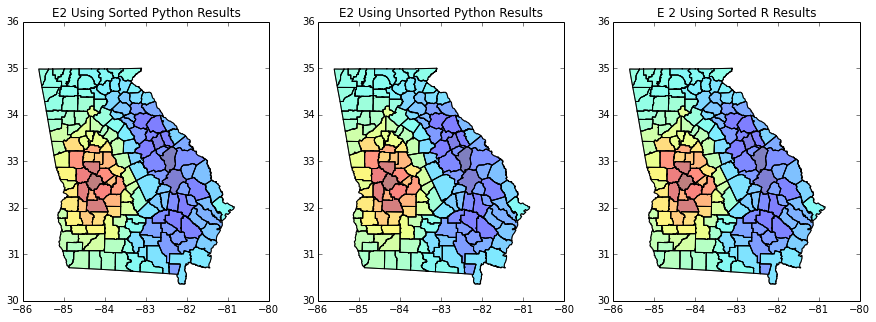

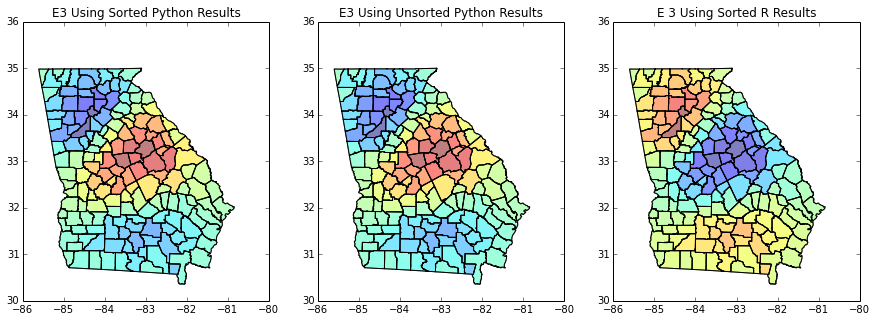

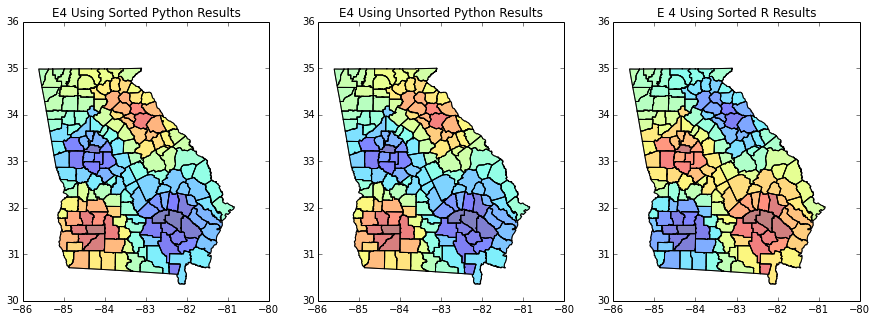

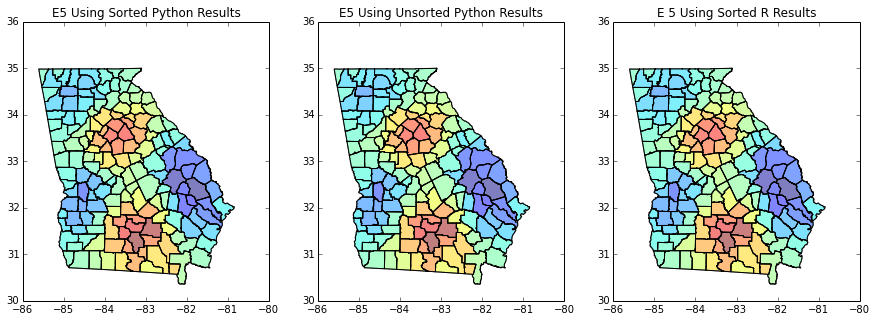

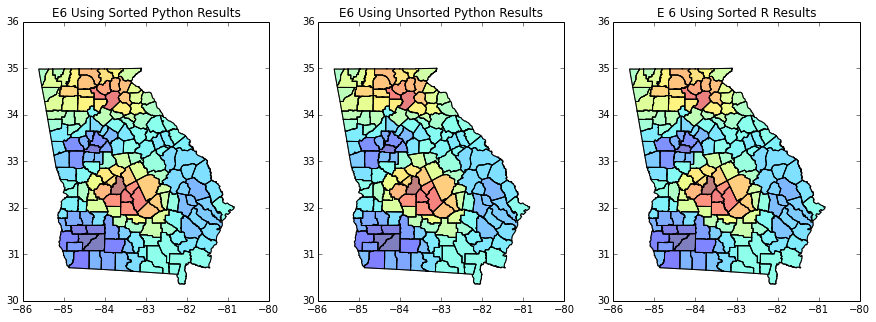

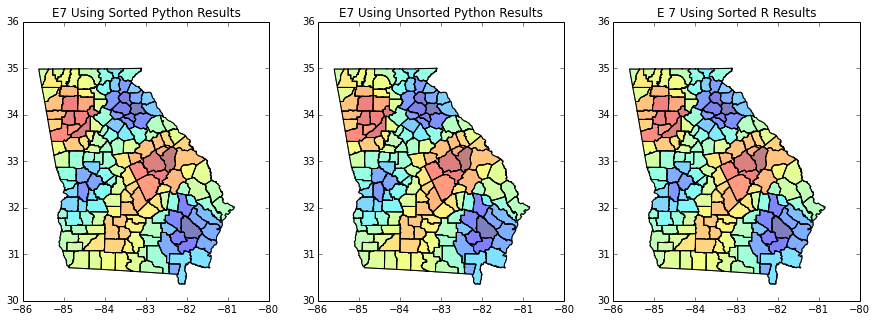

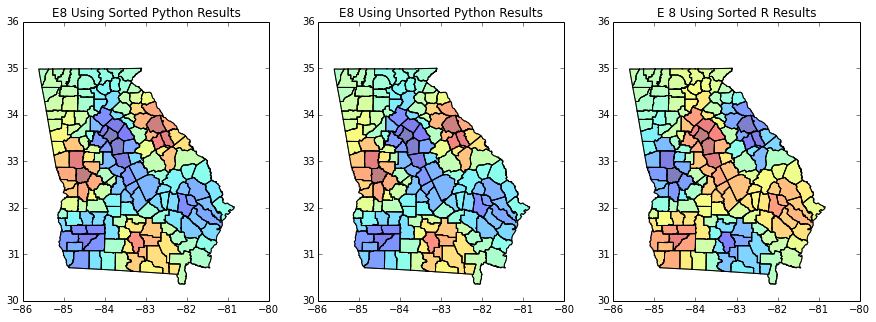

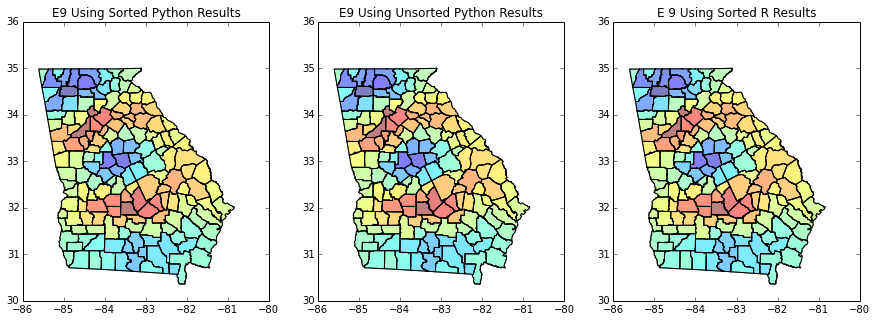

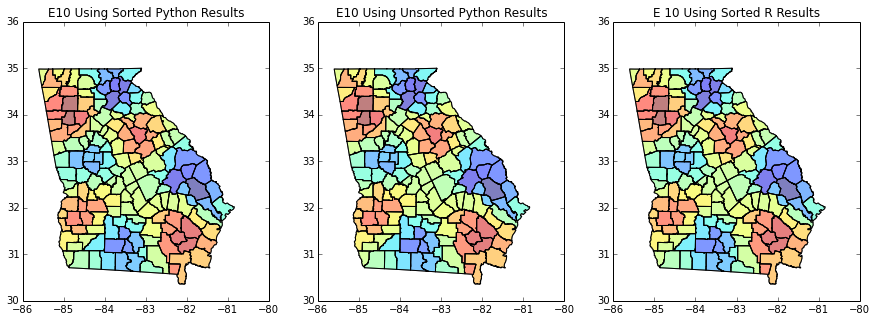

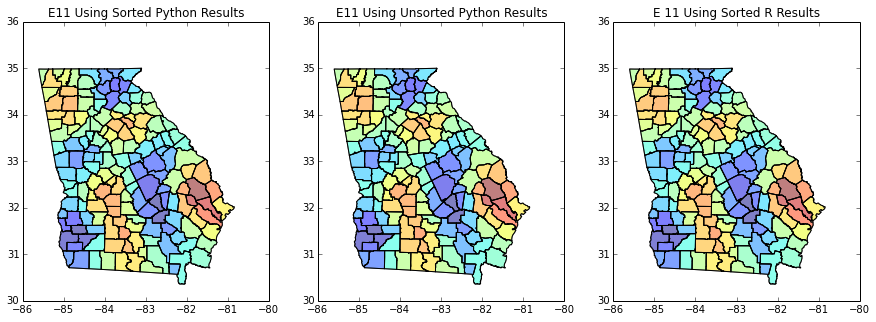

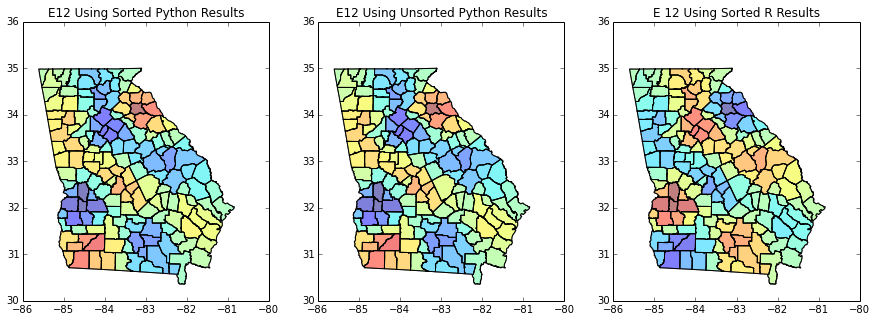

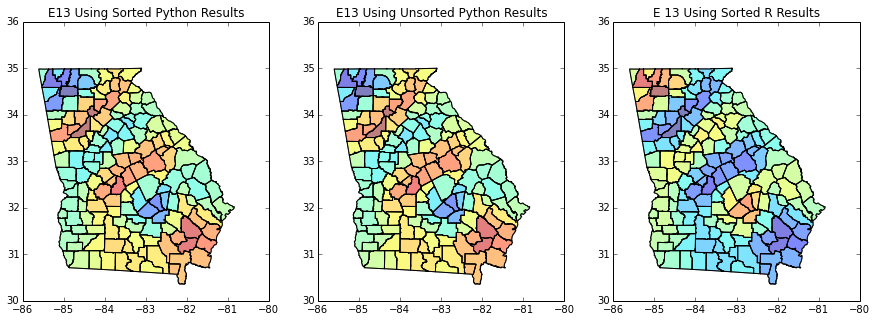

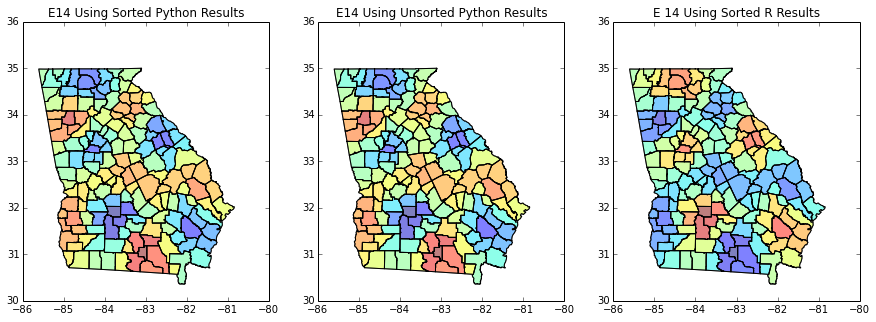

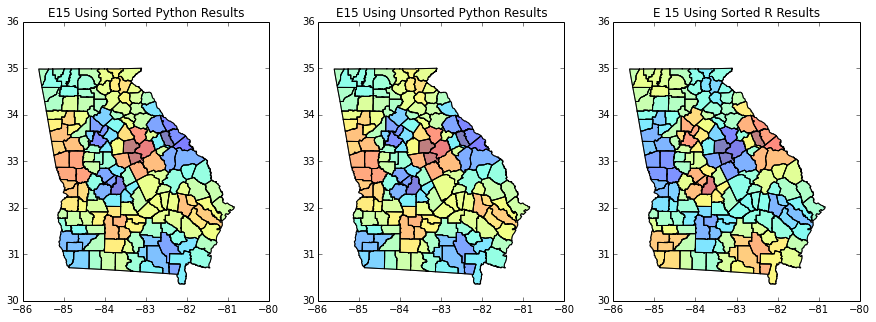

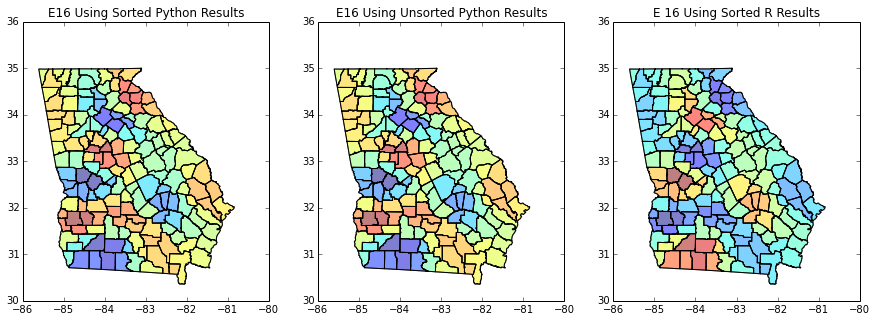

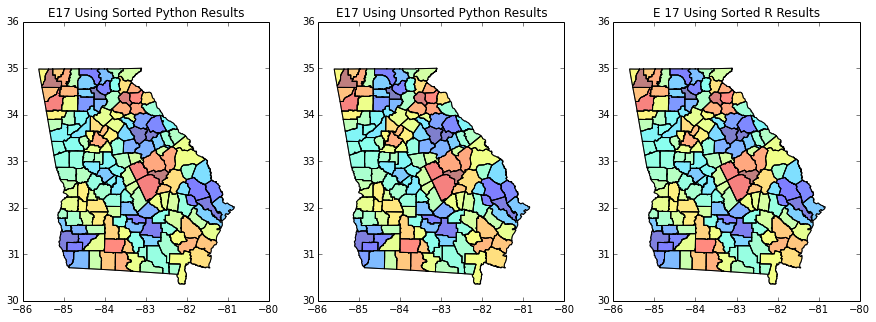

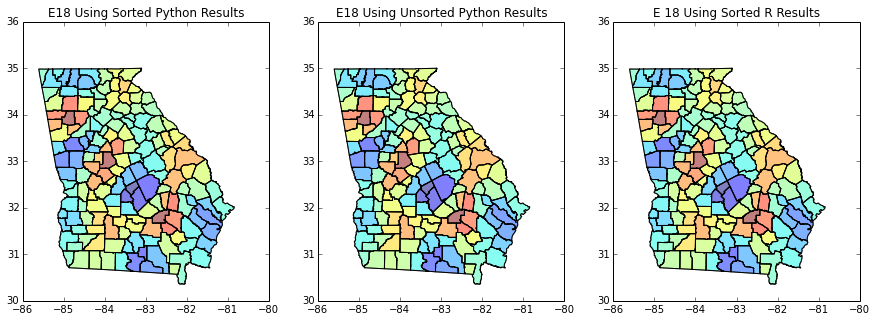

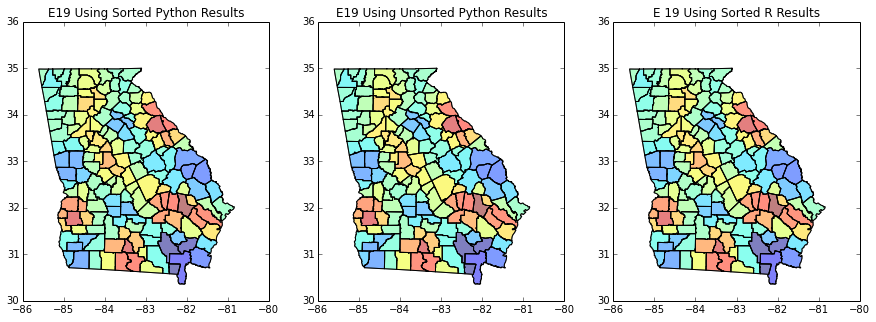

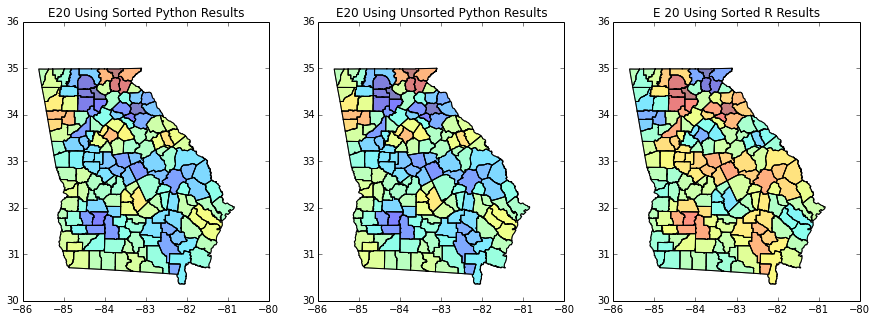

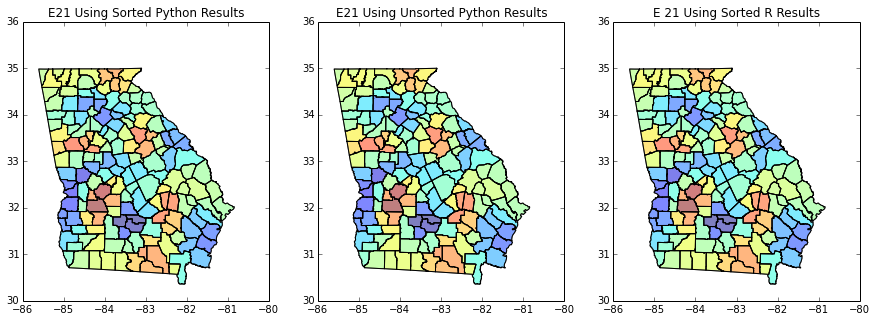

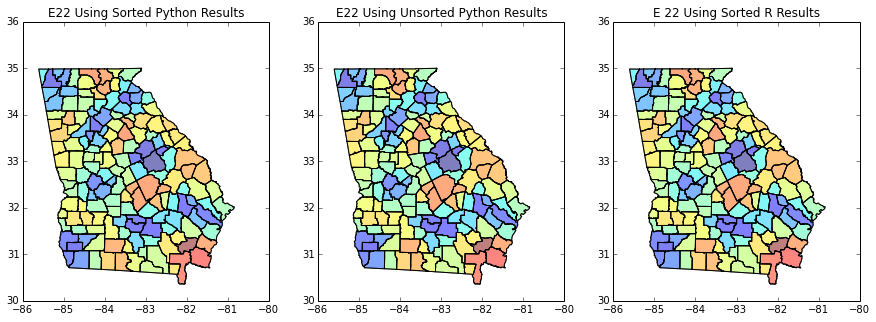

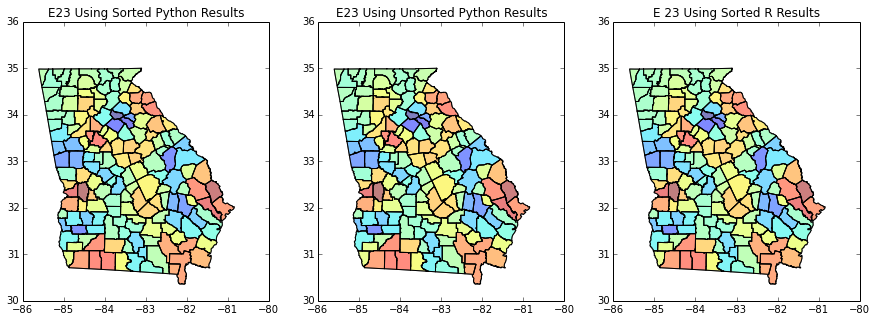

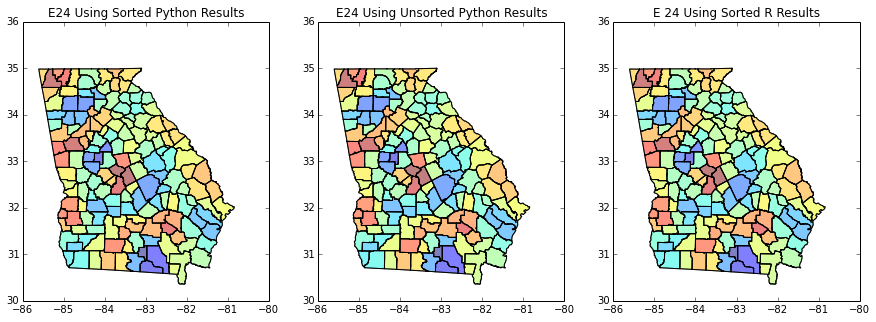

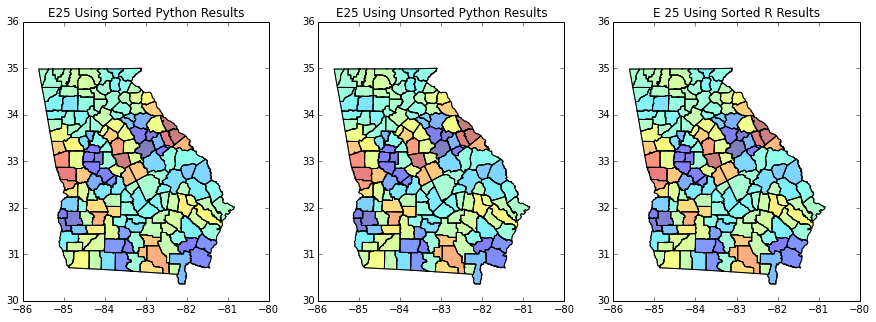

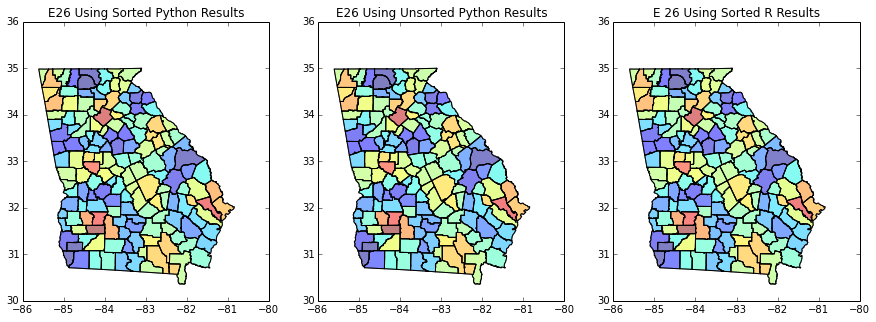

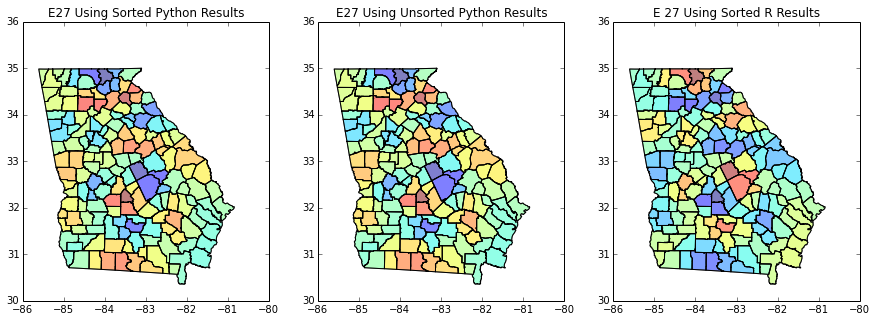

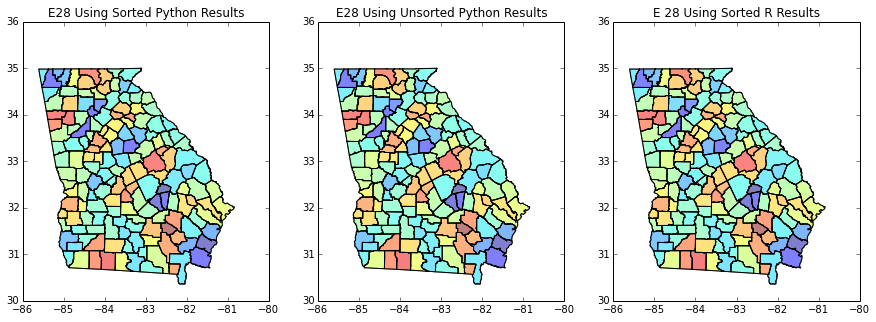

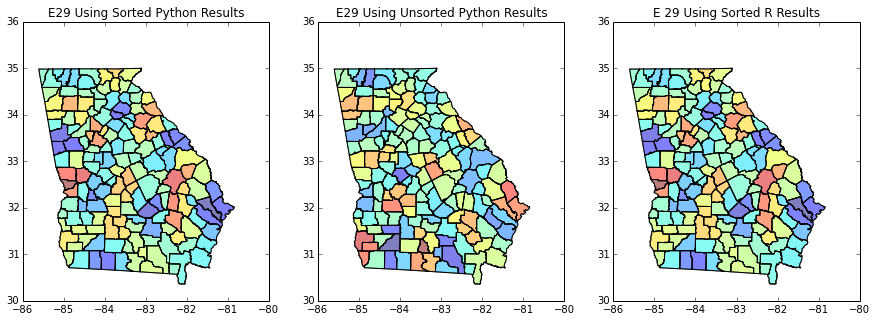

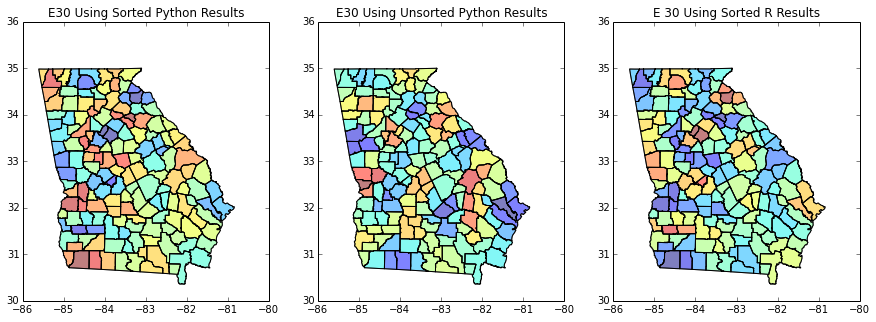

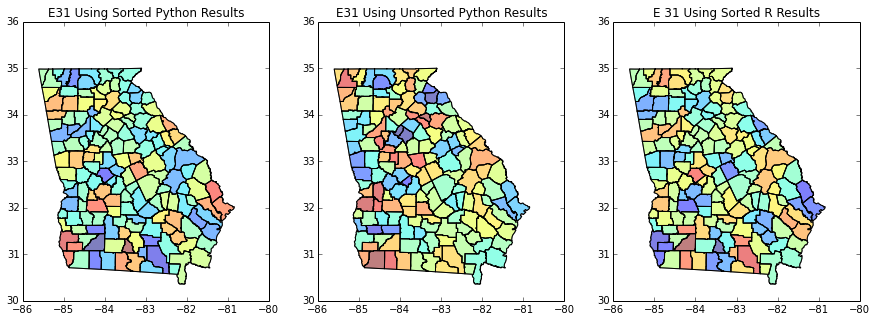

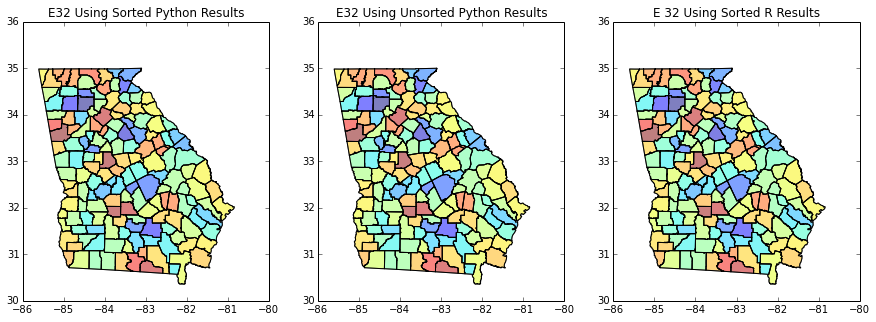

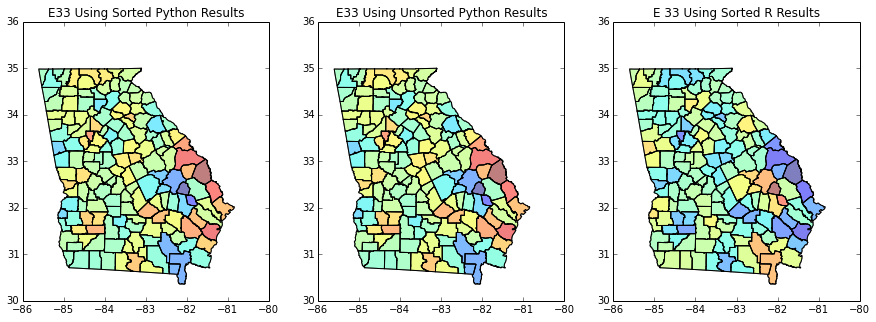

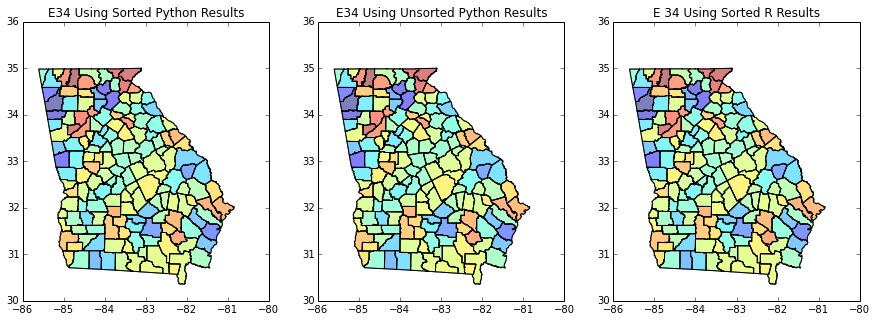

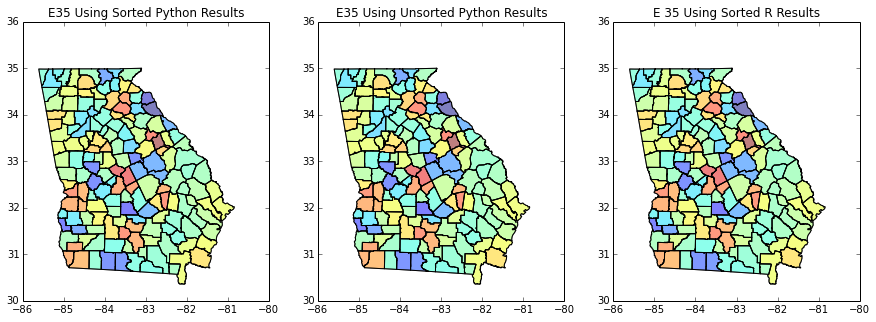

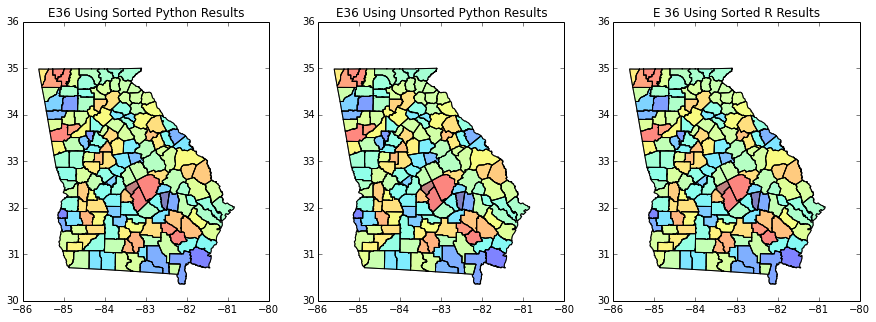

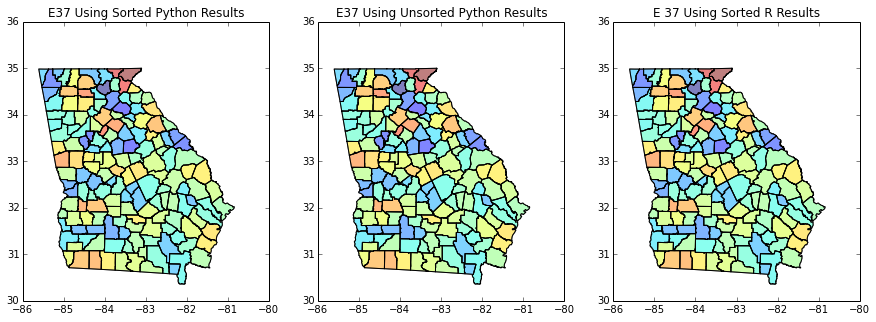

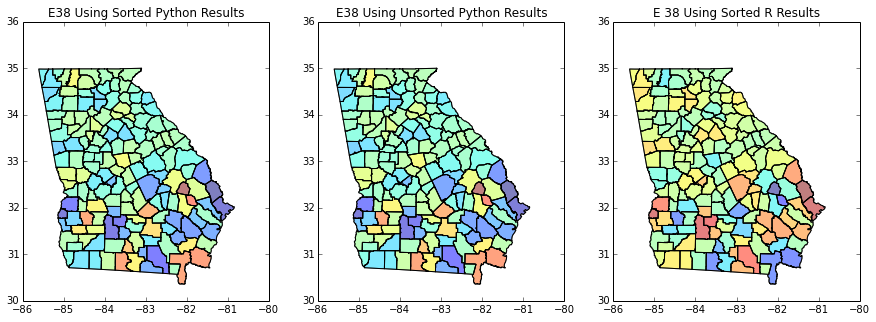

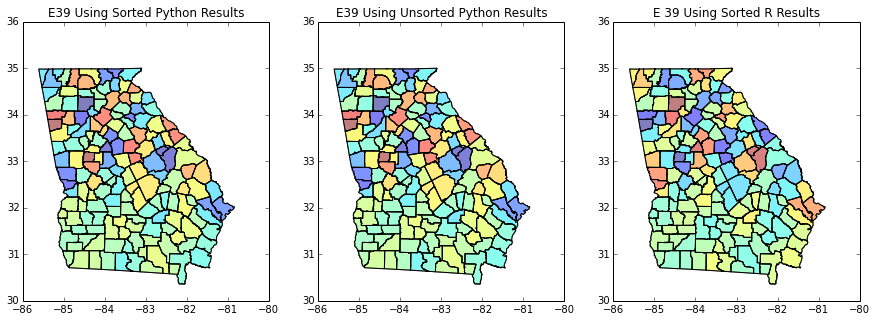

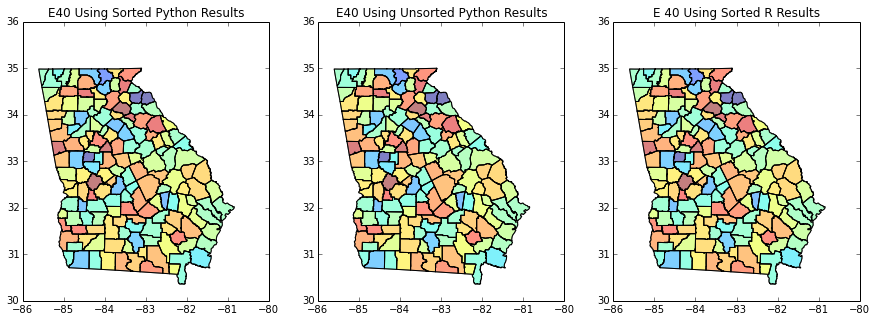

In [235]:
for x, eig in enumerate(new_vecs[:40]):
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    
    gshp['E' + str(x+1)] = eig
    axes[0].set_title('E' + str(x+1) + ' Using Sorted Python Results')
    gshp.plot('E' + str(x+1), axes=axes[0])
    
    
    gshp['E' + str(x+1)] = vecs[x]
    axes[1].set_title('E' + str(x+1) + ' Using Unsorted Python Results')
    gshp.plot('E' + str(x+1), axes=axes[1])
    
    gshp['E' + str(x+1)] = vecs_r[x]
    axes[2].set_title('E ' + str(x+1) + ' Using Sorted R Results')
    gshp.plot('E' + str(x+1), axes=axes[2])

    plt.plot()
    